In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 3a
commitnumber = f17e0b2
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [-2, 0]
ng_refs = [2, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(10, 250), (600, 250)]
tsfc = 257
w_diffuse = [(1.9, 1.7), (1.4, 1.4, 1.4, 1.55, 1.6, 1.66)]
wgt = [(0.7, 0.7), (0.7, 0.5, 0.5, 0.5, 0.5, 0.5)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

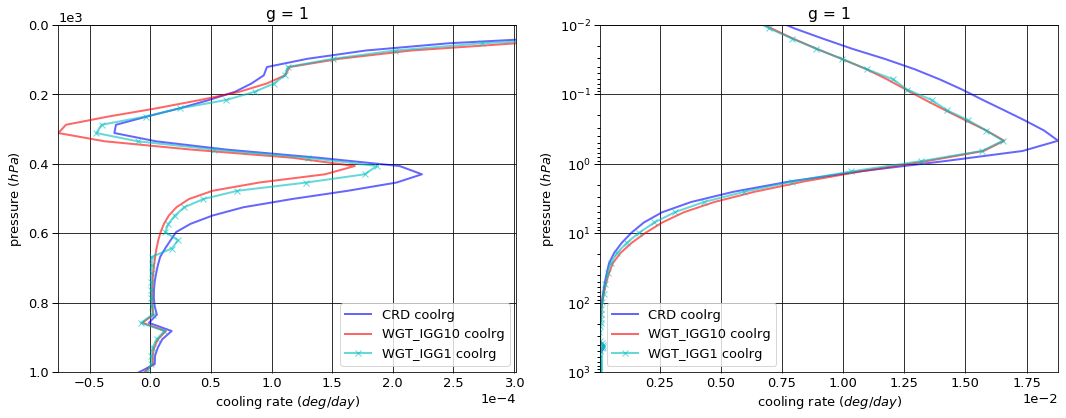

# Figure: cooling rate g-group 2

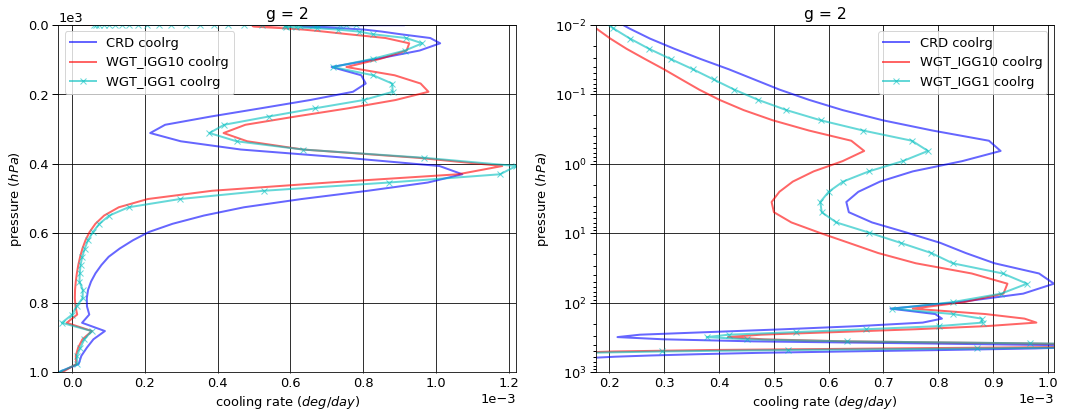

# Figure: cooling rate g-group 3

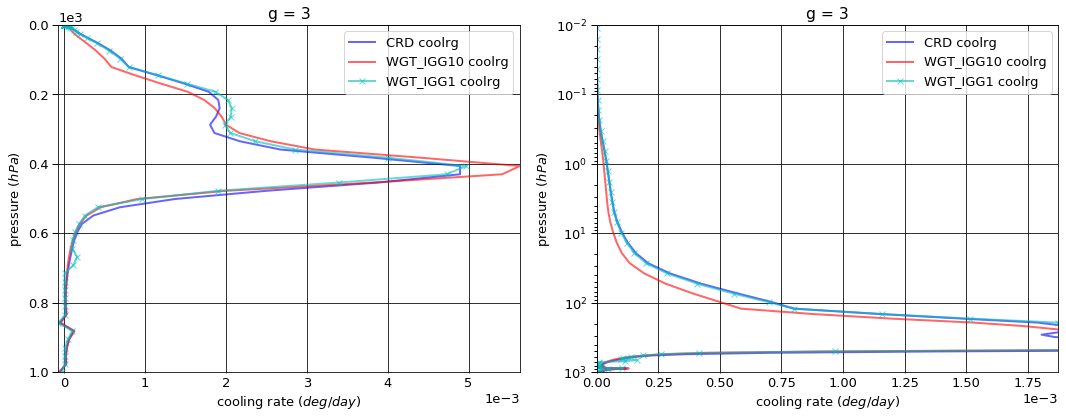

# Figure: cooling rate g-group 4

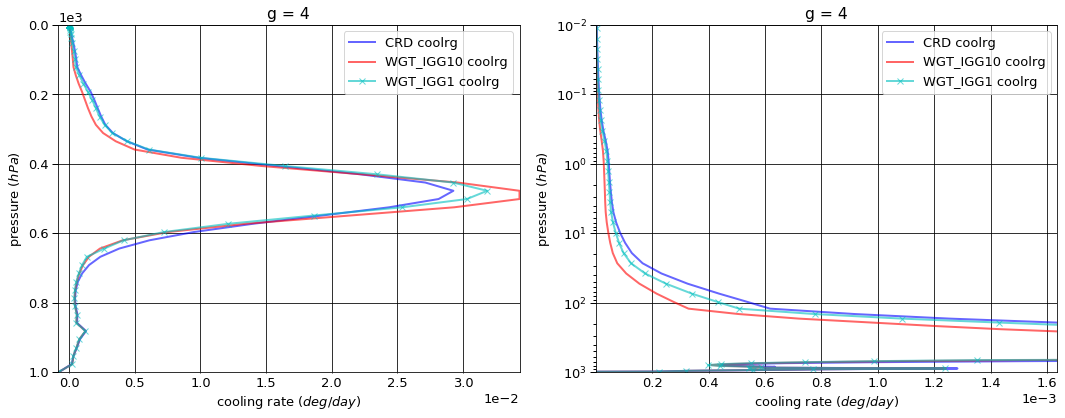

# Figure: cooling rate g-group 5

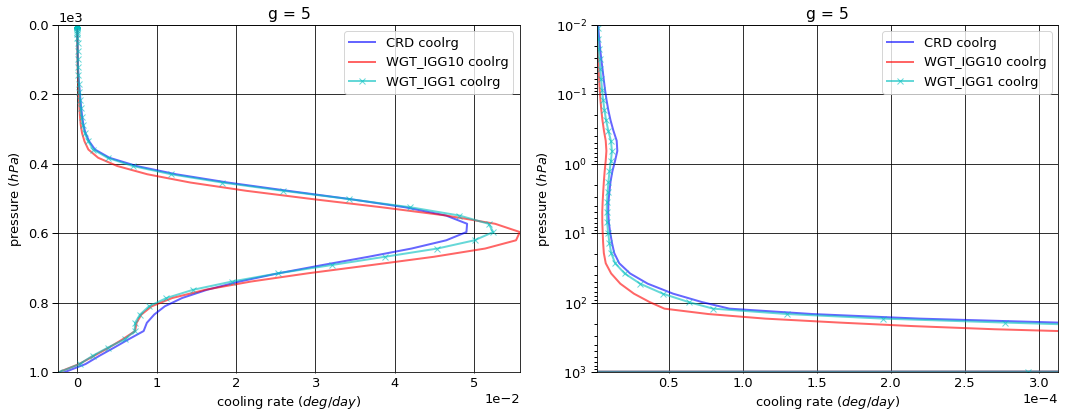

# Figure: cooling rate g-group 6

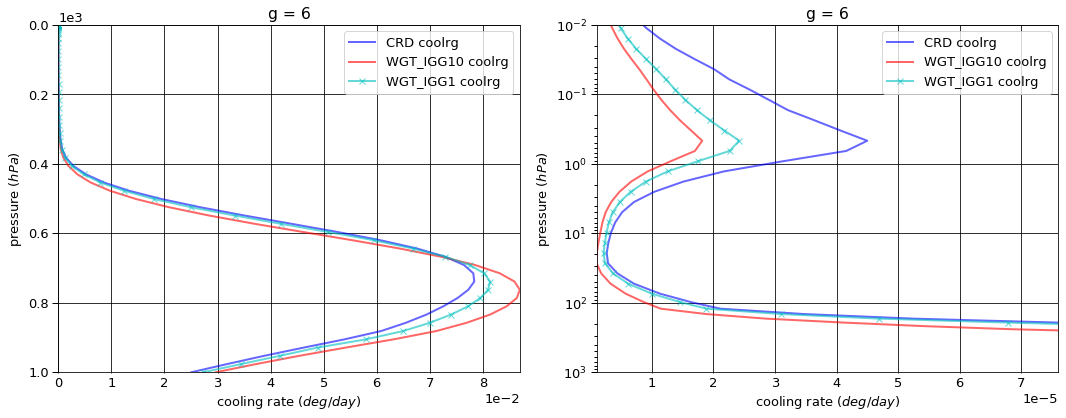

# Figure: cooling rate g-group 7

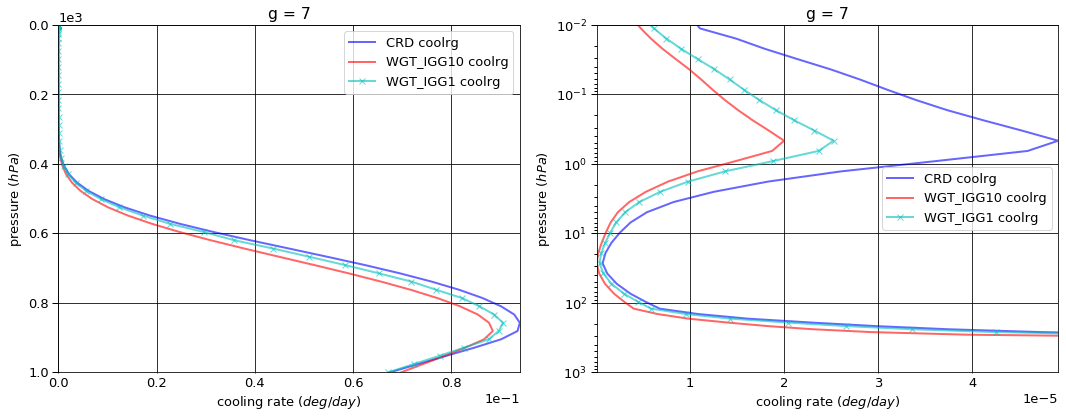

# Figure: cooling rate g-group 8

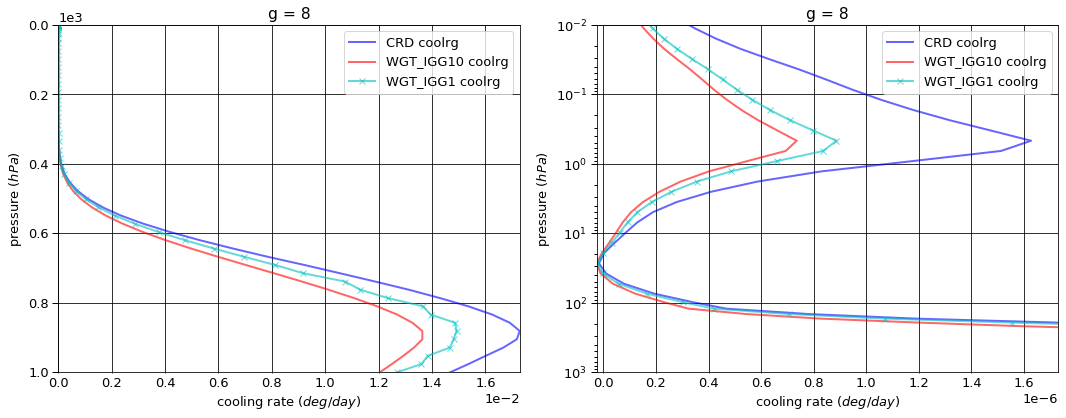

# Figure: cooling rate g-group total

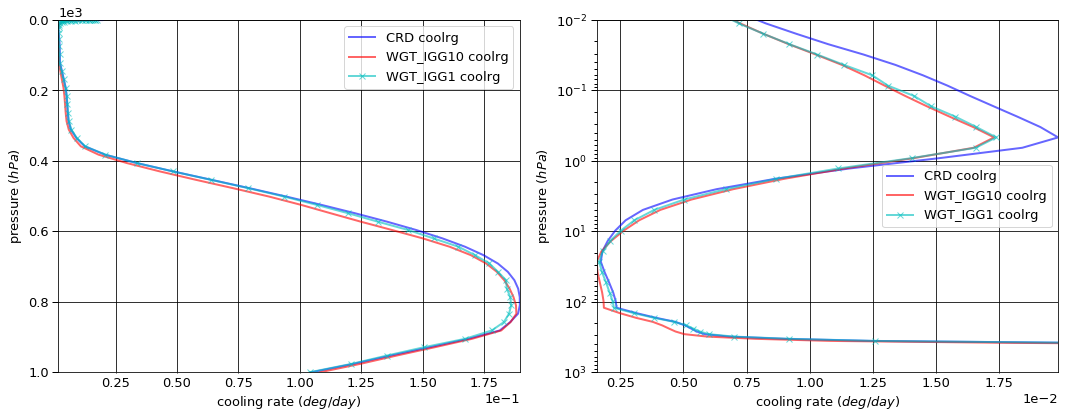

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.014015  0.000000  -0.014015
  1013.0   76     -0.023101  0.023138   0.000037
2 0.0      1      -0.049384  0.000000  -0.049384
  1013.0   76     -0.083764  0.083906   0.000143
3 0.0      1      -0.126315  0.000000  -0.126315
  1013.0   76     -0.208229  0.208443   0.000214
4 0.0      1      -0.698128  0.000000  -0.698128
  1013.0   76     -0.973641  0.976983   0.003343
5 0.0      1      -1.621304  0.000000  -1.621304
  1013.0   76     -1.923289  1.936913   0.013624
6 0.0      1      -4.253939  0.000000  -4.253939
  1013.0   76     -4.498851  3.801662  -0.697189
7 0.0      1     -10.492476  0.000000 -10.492476
  1013.0   76    -10.622071  4.055106  -6.566965
8 0.0      1      -5.242467  0.000000  -5.242467
  1013.0   76     -5.258194  0.687947  -4.570246


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.013482  0.000000  -0.013482
  1013.0   76     -0.023101  0.023119   0.000018
2 0.0      1      -0.046920  0.000000  -0.046920
  1013.0   76     -0.083764  0.083863   0.000099
3 0.0      1      -0.125983  0.000000  -0.125983
  1013.0   76     -0.208229  0.208443   0.000214
4 0.0      1      -0.704557  0.000000  -0.704557
  1013.0   76     -0.973641  0.976835   0.003195
5 0.0      1      -1.639588  0.000000  -1.639588
  1013.0   76     -1.923289  1.943216   0.019928
6 0.0      1      -4.290137  0.000000  -4.290137
  1013.0   76     -4.498851  3.948301  -0.550550
7 0.0      1     -10.525528  0.000000 -10.525528
  1013.0   76    -10.622071  3.646171  -6.975899
8 0.0      1      -5.246340  0.000000  -5.246340
  1013.0   76     -5.258194  0.538888  -4.719306


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.013577  0.000000  -0.013577
  1013.0   76     -0.023101  0.023111   0.000010
2 0.0      1      -0.047421  0.000000  -0.047421
  1013.0   76     -0.083764  0.083893   0.000130
3 0.0      1      -0.124620  0.000000  -0.124620
  1013.0   76     -0.208229  0.208320   0.000091
4 0.0      1      -0.693594  0.000000  -0.693594
  1013.0   76     -0.973641  0.976786   0.003146
5 0.0      1      -1.617419  0.000000  -1.617419
  1013.0   76     -1.923289  1.941686   0.018397
6 0.0      1      -4.263014  0.000000  -4.263014
  1013.0   76     -4.498851  3.885684  -0.613167
7 0.0      1     -10.502828  0.000000 -10.502828
  1013.0   76    -10.622071  3.867984  -6.754087
8 0.0      1      -5.243752  0.000000  -5.243752
  1013.0   76     -5.258194  0.603230  -4.654964


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1      5.329760e-04  0.000000e+00  5.329760e-04
  1013.0   76     0.000000e+00 -1.893100e-05 -1.893125e-05
2 0.0      1      2.464569e-03  0.000000e+00  2.464569e-03
  1013.0   76     0.000000e+00 -4.380200e-05 -4.380143e-05
3 0.0      1      3.320400e-04  0.000000e+00  3.320400e-04
  1013.0   76     0.000000e+00 -3.500000e-07 -3.507100e-07
4 0.0      1     -6.428650e-03  0.000000e+00 -6.428650e-03
  1013.0   76     0.000000e+00 -1.481000e-04 -1.480992e-04
5 0.0      1     -1.828410e-02  0.000000e+00 -1.828410e-02
  1013.0   76     2.220446e-16  6.303300e-03  6.303380e-03
6 0.0      1     -3.619700e-02  0.000000e+00 -3.619700e-02
  1013.0   76     0.000000e+00  1.466394e-01  1.466394e-01
7 0.0      1     -3.305200e-02  0.000000e+00 -3.305200e-02
  1013.0   76     0.000000e+00 -4.089345e-01 -4.089345e-01
8 0.0      1     -3.873300e-03  0.000000e+00 -3.873300e-03
  1013.0   76     0.000000e+00 -1.490594e-01 -1.490595e-01


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.376170e-04  0.000000  0.000438
  1013.0   76     0.000000e+00 -0.000027 -0.000027
2 0.0      1      1.963611e-03  0.000000  0.001964
  1013.0   76     0.000000e+00 -0.000013 -0.000013
3 0.0      1      1.695560e-03  0.000000  0.001696
  1013.0   76     0.000000e+00 -0.000124 -0.000124
4 0.0      1      4.533730e-03  0.000000  0.004534
  1013.0   76     0.000000e+00 -0.000197 -0.000197
5 0.0      1      3.885000e-03  0.000000  0.003885
  1013.0   76     2.220446e-16  0.004773  0.004773
6 0.0      1     -9.074000e-03  0.000000 -0.009074
  1013.0   76     0.000000e+00  0.084022  0.084022
7 0.0      1     -1.035200e-02  0.000000 -0.010352
  1013.0   76     0.000000e+00 -0.187122 -0.187122
8 0.0      1     -1.284700e-03  0.000000 -0.001285
  1013.0   76     0.000000e+00 -0.084718 -0.084718

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      1.949074e-03
  1001.112500 75    -9.422865e-06
2 0.000312    1      5.485479e-05
  1001.112500 75    -3.768328e-05
3 0.000312    1      2.420018e-09
  1001.112500 75    -5.631970e-05
4 0.000312    1      5.929265e-07
  1001.112500 75    -8.104590e-04
5 0.000312    1      2.752749e-07
  1001.112500 75    -1.643555e-03
6 0.000312    1      5.632784e-07
  1001.112500 75     2.503446e-02
7 0.000312    1      2.242162e-07
  1001.112500 75     6.752164e-02
8 0.000312    1     -1.695551e-08
  1001.112500 75     1.467875e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      2.160489e-03
  1001.112500 75    -5.063723e-06
2 0.000312    1      5.009574e-05
  1001.112500 75    -2.725812e-05
3 0.000312    1      1.554305e-09
  1001.112500 75    -5.938422e-05
4 0.000312    1      3.226335e-07
  1001.112500 75    -8.246094e-04
5 0.000312    1      1.185205e-07
  1001.112500 75    -2.386755e-03
6 0.000312    1      8.701107e-08
  1001.112500 75     2.963461e-02
7 0.000312    1     -1.115798e-07
  1001.112500 75     6.979959e-02
8 0.000312    1     -1.045910e-08
  1001.112500 75     1.204496e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.002265e-03
  1001.112500 75    -2.926126e-06
2 0.000312    1      5.946729e-05
  1001.112500 75    -3.558189e-05
3 0.000312    1      2.348344e-09
  1001.112500 75    -2.637366e-05
4 0.000312    1      5.362420e-07
  1001.112500 75    -8.148747e-04
5 0.000312    1      2.313731e-07
  1001.112500 75    -2.305888e-03
6 0.000312    1      2.916540e-07
  1001.112500 75     2.729600e-02
7 0.000312    1     -1.397749e-08
  1001.112500 75     6.718721e-02
8 0.000312    1     -1.097545e-08
  1001.112500 75     1.269536e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.114154e-04
  1001.112500 75     4.359142e-06
2 0.000312    1     -4.759048e-06
  1001.112500 75     1.042515e-05
3 0.000312    1     -8.657127e-10
  1001.112500 75    -3.064516e-06
4 0.000312    1     -2.702930e-07
  1001.112500 75    -1.415038e-05
5 0.000312    1     -1.567544e-07
  1001.112500 75    -7.432007e-04
6 0.000312    1     -4.762673e-07
  1001.112500 75     4.600143e-03
7 0.000312    1     -3.357960e-07
  1001.112500 75     2.277952e-03
8 0.000312    1      6.496410e-09
  1001.112500 75    -2.633792e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      5.319100e-05
  1001.112500 75     6.496739e-06
2 0.000312    1      4.612504e-06
  1001.112500 75     2.101384e-06
3 0.000312    1     -7.167360e-11
  1001.112500 75     2.994604e-05
4 0.000312    1     -5.668448e-08
  1001.112500 75    -4.415750e-06
5 0.000312    1     -4.390180e-08
  1001.112500 75    -6.623329e-04
6 0.000312    1     -2.716244e-07
  1001.112500 75     2.261531e-03
7 0.000312    1     -2.381937e-07
  1001.112500 75    -3.344300e-04
8 0.000312    1      5.980059e-09
  1001.112500 75    -1.983389e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.498029,0.000000,-22.498029
1013.0,76,-23.591138,11.774099,-11.817039



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.592535,0.000000,-22.592535
1013.0,76,-23.591138,11.368837,-12.222301



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.506224,0.000000,-22.506224
1013.0,76,-23.591138,11.590694,-12.000444



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.094505,0.000000,-0.094505
1013.0,76,0.000000,-0.405262,-0.405262



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.008195,0.000000,-0.008195
1013.0,76,0.000000,-0.183405,-0.183405


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.002006
1001.112500,75,0.104677



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.002211
1001.112500,75,0.108176



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.002063
1001.112500,75,0.103993



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000205
1001.112500,75,0.003499



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000057
1001.112500,75,-0.000684


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000975,0.000980
2,0.003537,0.003553
3,0.008788,0.008834
4,0.041113,0.041304
5,0.081162,0.081606
6,0.189850,0.190885
7,0.449437,0.450426
8,0.225137,0.222410


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.721336e-20
2,2.922656e-21
3,5.198265e-21
4,9.729649e-22
5,1.821109e-22
6,3.408590e-23
7,6.379894e-24
8,1.194132e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.721336e-20,NaN,0.000975,0.000980,0.000975,0.000980,10.0
2,2.922656e-21,0.051083,0.003537,0.003553,0.004513,0.004534,10.0
3,5.198265e-21,1.778610,0.008788,0.008834,0.013300,0.013368,600.0
4,9.729649e-22,0.187171,0.041113,0.041304,0.054413,0.054672,600.0
5,1.821109e-22,0.187171,0.081162,0.081606,0.135575,0.136279,600.0
6,3.408590e-23,0.187171,0.189850,0.190885,0.325425,0.327164,600.0
7,6.379894e-24,0.187171,0.449437,0.450426,0.774863,0.777590,600.0
8,1.194132e-24,0.187171,0.225137,0.222410,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
